# Pose Estimation Fine Tuninig with Super Gradients

In this tutorial notebook we demonstrate how to fine tune a pose estimation model using SuperGradients. It is recommended that you go over [Pose Estimation tutorial](https://docs.deci.ai/super-gradients/documentation/source/PoseEstimation.html) docs first to get familiar with terminology and concepts we use here.

From this tutorial you will learn:
* How to implement a custom dataset class for pose estimation task
* How to instantiate a pre-trained pose estimation model and change number of joints it predicts to fit your dataset
* How to fine-tune a pose estimation model using SuperGradients
* How to visualize training progress and results in Tensorboard



In [1]:
!pip install super_gradients==3.3.1 scikit-learn gwpy &> /dev/null

## Dataset

The first thing we need is our dataset. For this tutorial we will be using [Animals Pose](https://sites.google.com/view/animal-pose/) dataset. It is a relatively small dataset of 6K+ instances of animals, each annotated with 20 keypoints.

![](https://lh6.googleusercontent.com/hehW9yRzdcniQ2i1Ts65ceGERa70cBbaLlRixxu7HlUMHabt8HdgcxutG4vmVOas-U1h6g=w16383)

### Download dataset from here

https://drive.google.com/drive/folders/1xxm6ZjfsDSmv6C9JvbgiGrmHktrUjV5x?usp=sharing

You need to download the Animal Pose Dataset from Google Drive and update `ANIMALS_POSE_DATA_DIR` to point to this location:


In [2]:
!pip install gdown
!gdown https://drive.google.com/file/d/1BWZ2aMl2CVgDwRJ214TPvZey_F9GMfTq/view?usp=share_link --fuzzy -q
!gdown https://drive.google.com/file/d/1AZEEYwAe41_FYtSh0G61oIutskMdRFUk/view?usp=share_link --fuzzy -q
!unzip -q -o "images.zip"
!ls -l /content

total 361676
drwxrwxrwx 2 root root    147456 Jul 22  2021 images
-rw-r--r-- 1 root root 367834726 Oct 30 16:35 images.zip
-rw-r--r-- 1 root root   2358051 Oct 30 16:35 keypoints.json
drwxr-xr-x 1 root root      4096 Oct 27 13:22 sample_data


In [3]:
ANIMALS_POSE_DATA_DIR = "/content"

## Dataset preparation

Animals Pose dataset uses COCO-style annotation format.
Unfortunately it's not 100% compatible with COCO parser from `pycocotools`.
So we have to write out own parser. That is not a big issue, since the format is very simple.
There are 3 main parts of the annotation file: "images", "annotations" and "categories".

Here is an example of the annotation file:

```json
{
    "images": {
        "1": "2007_000063.jpg",
        "2": "2007_000175.jpg",
        "6": "2007_000491.jpg",
        ...
        "4606": "sh97.jpg",
        "4607": "sh98.jpeg",
        "4608": "sh99.jpeg"
    },
    "annotations": [
        {
            "image_id": 1,
            "bbox": [123, 115, 379, 275],
            "keypoints": [
                [193, 216, 1],
                [160, 217, 1],
                ...,
                [190, 145, 1],
                [351, 238, 1]
            ],
            "num_keypoints": 20,
            "category_id": 1
        },
        ...
    ],
    "categories": [
        {
            "supercategory": "animal",
            "id": 1,
            "name": "dog",
            "keypoints": [
                "left_eye",
                "right_eye",
                ...
                "throat",
                "withers",
                "tailbase"
            ],
            "skeleton": [
                [0, 1],
                [0, 2],
                ...
                [11, 15],
                [12, 16]
            ]
        },
```


## Train / Val split

Before we start training, we have to splint our dataset into training & validation parts. Since official dataset does not provide such split, we will pick the most simple approach here - a stratified split with ratio of 80/20% for train and test respectively. A stratification will be performed based on animal type to ensure we have all species in both splits.

In [4]:
import json
from sklearn.model_selection import train_test_split


def split_animal_pose_dataset(annotation_file: str, train_annotation_file: str, val_annotation_file: str, val_fraction: float):
    with open(annotation_file, "r") as f:
        annotation = json.load(f)

    image_ids = list(annotation["images"].keys())
    labels = [[ann["category_id"] for ann in annotation["annotations"] if ann["image_id"] == image_id] for image_id in image_ids]
    labels = [label[0] if len(label) else -1 for label in labels]

    train_ids, val_ids = train_test_split(image_ids, test_size=val_fraction, random_state=42, stratify=labels)

    train_annotations = {
        "info": annotation["info"],
        "categories": annotation["categories"],
        "images": dict((image_id, annotation["images"][image_id]) for image_id in train_ids),
        "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in train_ids],
    }

    val_annotations = {
        "info": annotation["info"],
        "categories": annotation["categories"],
        "images": dict((image_id, annotation["images"][image_id]) for image_id in val_ids),
        "annotations": [ann for ann in annotation["annotations"] if str(ann["image_id"]) in val_ids],
    }

    with open(train_annotation_file, "w") as f:
        json.dump(train_annotations, f)
        print("Train annotations saved to", train_annotation_file)
        print("Train images:", len(train_ids))
        print("Train annotations:", len(train_annotations["annotations"]))

    with open(val_annotation_file, "w") as f:
        json.dump(val_annotations, f)
        print("Val annotations saved to", val_annotation_file)
        print("Val images:", len(val_ids))
        print("Val annotations:", len(val_annotations["annotations"]))


The function `split_animal_pose_dataset` takes full JSON file and split it into two files for train & validation datasets.

In [5]:
split_animal_pose_dataset(
    annotation_file = "/content/keypoints.json",
    train_annotation_file = "/content/train_keypoints.json",
    val_annotation_file = "/content/val_keypoints.json",
    val_fraction = 0.2
)

Train annotations saved to /content/train_keypoints.json
Train images: 3686
Train annotations: 4938
Val annotations saved to /content/val_keypoints.json
Val images: 922
Val annotations: 1179


## Writing a custom dataset class

To train pose estimation model using Super Gradients we need to implement a custom dataset class that will parse this format and return images and targets for the model.
Fortunately, Super Gradients provides a base class for pose estimation datasets that handles most of the boilerplate code for us.


We need to implement a dataset parsing method that will return annotations in a format that Super Gradients expects.
The dataset class is expected to have the following method signature:

```python
class AnimalsPoseDataset:
    def __getitem__(self, index):
        ...
        return image, targets, {"gt_joints": gt_joints, "gt_bboxes": gt_bboxes, "gt_iscrowd": gt_iscrowd, "gt_areas": gt_areas}
```

The `__getitem__` method is expected to return a tuple of 3 elements `image`, `targets` and `extras`:

* `image` - torch tensor of [C,H,W] shape that represents an input image to the model.
* `targets` - model-specific targets to train the model itself. Fortunately SG will take care of generating these targets for us. Our goal is to provide the keypoints of [Num Instances, Num Joints, 3] shape.
* `extras` - Additional information with poses for metric computation. Must be a dictionary with following keys:
    * gt_joints - Array of keypoints for all poses in the image. Numpy array of [Num Instances, Num Joints, 3] shape
    * gt_bboxes - Array of bounding boxes (XYWH) for each pose in the image. Numpy array of [Num Instances, 4] shape
    * gt_iscrowd - Array of iscrowd flags for each pose in the image. Numpy array of [Num Instances] shape
    * gt_areas - Array of areas for each skeleton in the image. Numpy array of [Num Instances] shape

In [28]:
import json
import os
from typing import List, Mapping, Any, Tuple

import cv2
import numpy as np
from torch import Tensor

from super_gradients.common.decorators.factory_decorator import resolve_param
from super_gradients.common.factories.target_generator_factory import TargetGeneratorsFactory
from super_gradients.common.factories.transforms_factory import TransformsFactory
from super_gradients.training.datasets.pose_estimation_datasets import BaseKeypointsDataset
from super_gradients.training.transforms.keypoint_transforms import KeypointTransform


class AnimalPoseKeypointsDataset(BaseKeypointsDataset):
    """
    Dataset class for training pose estimation models on Animal Pose dataset.
    User should pass a target generator class that is model-specific and generates the targets for the model.
    """

    @resolve_param("transforms", TransformsFactory())
    @resolve_param("target_generator", TargetGeneratorsFactory())
    def __init__(
        self,
        data_dir: str,
        images_dir: str,
        json_file: str,
        include_empty_samples: bool,
        target_generator,
        transforms: List[KeypointTransform],
        min_instance_area: float,
        **kwargs
    ):
        """

        :param data_dir: Root directory of the COCO dataset
        :param images_dir: path suffix to the images directory inside the data_dir
        :param json_file: path suffix to the json file inside the data_dir
        :param include_empty_samples: Not used, but exists for compatibility with COCO dataset config.
        :param target_generator: Target generator that will be used to generate the targets for the model.
            See DEKRTargetsGenerator for an example.
        :param transforms: Transforms to be applied to the image & keypoints
        :param min_instance_area: Minimum area of an instance to be included in the dataset
        """
        with open(os.path.join(data_dir, json_file), "r") as f:
            json_annotations = json.load(f)
        joints = json_annotations["categories"][0]["keypoints"]
        skeleton = json_annotations["categories"][0]["skeleton"]

        num_joints = len(joints)

        super().__init__(transforms=transforms, target_generator=target_generator, min_instance_area=min_instance_area, num_joints=num_joints, edge_links=skeleton, edge_colors=None, keypoint_colors=None)


        self.joints = joints
        self.num_joints = num_joints

        images_and_ids = [(image_id, os.path.join(data_dir, images_dir, image_path)) for image_id, image_path in json_annotations["images"].items()]
        self.image_ids, self.image_files = zip(*images_and_ids)

        self.annotations = []

        for image_id in self.image_ids:
            keypoints_per_image = []
            bboxes_per_image = []

            image_annotations = [ann for ann in json_annotations["annotations"] if str(ann["image_id"]) == str(image_id)]
            for ann in image_annotations:
                keypoints = np.array(ann["keypoints"]).reshape(self.num_joints, 3)
                x1, y1, x2, y2 = ann["bbox"]

                bbox_xywh = np.array([x1, y1, x2 - x1, y2 - y1])
                keypoints_per_image.append(keypoints)
                bboxes_per_image.append(bbox_xywh)

            keypoints_per_image = np.array(keypoints_per_image, dtype=np.float32).reshape(-1, self.num_joints, 3)
            bboxes_per_image = np.array(bboxes_per_image, dtype=np.float32).reshape(-1, 4)
            annotation = keypoints_per_image, bboxes_per_image
            self.annotations.append(annotation)

    def __len__(self):
        return len(self.image_ids)

    def load_sample(self, index):
        file_path = self.image_files[index]
        gt_joints, gt_bboxes = self.annotations[index]  # boxes in xywh format

        gt_areas = np.array([box[2] * box[3] for box in gt_bboxes], dtype=np.float32)
        gt_iscrowd = np.array([0] * len(gt_joints), dtype=bool)

        image = cv2.imread(file_path, cv2.IMREAD_COLOR)
        mask = np.ones(image.shape[:2], dtype=np.float32)

        return image, mask, gt_joints, gt_areas, gt_bboxes, gt_iscrowd

    def __getitem__(self, index: int) -> Tuple[Tensor, Any, Mapping[str, Any]]:
        img, mask, gt_joints, gt_areas, gt_bboxes, gt_iscrowd = self.load_sample(index)
        img, mask, gt_joints, gt_areas, gt_bboxes = self.transforms(img, mask, gt_joints, areas=gt_areas, bboxes=gt_bboxes)

        image_shape = img.size(1), img.size(2)
        gt_joints, gt_areas, gt_bboxes, gt_iscrowd = self.filter_joints(image_shape, gt_joints, gt_areas, gt_bboxes, gt_iscrowd)

        targets = self.target_generator(img, gt_joints, mask)
        return img, targets, {"gt_joints": gt_joints, "gt_bboxes": gt_bboxes, "gt_iscrowd": gt_iscrowd, "gt_areas": gt_areas}

    def filter_joints(
        self,
        image_shape,
        joints: np.ndarray,
        areas: np.ndarray,
        bboxes: np.ndarray,
        is_crowd: np.ndarray,
    ):
        """
        Filter instances that are either too small or do not have visible keypoints.

        :param image: Image if [H,W,C] shape. Used to infer image boundaries
        :param joints: Array of shape [Num Instances, Num Joints, 3]
        :param areas: Array of shape [Num Instances] with area of each instance.
                      Instance area comes from segmentation mask from COCO annotation file.
        :param bboxes: Array of shape [Num Instances, 4] for bounding boxes in XYWH format.
                       Bounding boxes comes from segmentation mask from COCO annotation file.
        :param: is_crowd: Array of shape [Num Instances] indicating whether an instance is a crowd target.
        :return: [New Num Instances, Num Joints, 3], New Num Instances <= Num Instances
        """

        # Update visibility of joints for those that are outside the image
        outside_image_mask = (joints[:, :, 0] < 0) | (joints[:, :, 1] < 0) | (joints[:, :, 0] >= image_shape[1]) | (joints[:, :, 1] >= image_shape[0])
        joints[outside_image_mask, 2] = 0

        # Filter instances with all invisible keypoints
        instances_with_visible_joints = np.count_nonzero(joints[:, :, 2], axis=-1) > 0
        instances_with_good_area = areas > self.min_instance_area

        keep_mask = instances_with_visible_joints & instances_with_good_area

        joints = joints[keep_mask]
        areas = areas[keep_mask]
        bboxes = bboxes[keep_mask]
        is_crowd = is_crowd[keep_mask]

        return joints, areas, bboxes, is_crowd


Let's recap what are the responsibilities of `AnimalPoseKeypointsDataset` class:

- Load annotations from JSON file in COCO format
- Unpack annotations into keypoints and bounding boxes
- Implements a `__getitem__` method for retrieving individual image with corresponding annotations
- Apply preprocessing and data augmentation transforms to the image and annotations
- Encodes a "human friendly" joints representation (Array of `[Num Instances, Num Joints, 3]` shape) into a format suitable for training Yolo-NAS (Tuple of two tensors `[NumJoints + 1, H/4, W/4]`, `[NumJoints*2, H/4, W/4]`).


Now, when we have the dataset class we can instantiate DataLoaders.
Since our fine-tuning tasks is really similar to COCO human pose estimation task we can take COCO dataset configs as base ones and use transforms & target generator from these configs:

In [7]:
from typing import Dict
from torch.utils.data import DataLoader
from super_gradients.training.dataloaders import get_data_loader

def animalpose_pose_train(dataset_params: Dict = None, dataloader_params: Dict = None) -> DataLoader:
    return get_data_loader(
        config_name="coco_pose_estimation_dekr_dataset_params",
        dataset_cls=AnimalPoseKeypointsDataset,
        train=True,
        dataset_params=dataset_params,
        dataloader_params=dataloader_params,
    )


def animalpose_pose_val(dataset_params: Dict = None, dataloader_params: Dict = None) -> DataLoader:
    return get_data_loader(
        config_name="coco_pose_estimation_dekr_dataset_params",
        dataset_cls=AnimalPoseKeypointsDataset,
        train=False,
        dataset_params=dataset_params,
        dataloader_params=dataloader_params,
    )

We are almost ready to instantiate our data loaders. There is only one important nuance that we have to cover. Let's instantiate our train dataset and inspect the transformations that we apply to our samples:



In [8]:
from pprint import pprint

train_data = animalpose_pose_train(
    dataset_params=dict(data_dir=ANIMALS_POSE_DATA_DIR, images_dir="images", json_file="train_keypoints.json"),
    dataloader_params=dict(num_workers=0, batch_size=8)
)
train_data.dataset.transforms.transforms

[KeypointsLongestMaxSize(max_height=640, max_width=640, interpolation=1, prob=1.0),
 KeypointsPadIfNeeded(min_height=640, min_width=640, image_pad_value=127, mask_pad_value=1, padding_mode=bottom_right, ),
 KeypointsRandomHorizontalFlip(flip_index=[0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15], prob=0.5),
 KeypointsRandomAffineTransform(max_rotation=30, min_scale=0.5, max_scale=2, max_translate=0.2, image_pad_value=127, mask_pad_value=1, prob=0.75),
 KeypointsImageStandardize(max_value=255),
 KeypointsImageNormalize(mean=[[[0.485 0.456 0.406]]], std=[[[0.229 0.224 0.225]]]),
 KeypointsImageToTensor()]

During training we apply several augmentations to our samples. There is one, however that needs out special attention, which is KeypointsRandomHorizontalFlip.
When working with object detection and semantic segmentation we can safely skip the fact that left and right in flipped image changing sides.
However, in pose estimation of objects that possess vertical symmetry, like animals or humans, we have to take this into account.
So when we flip the image we also have to swap left and right keypoints. In order to do this correctly KeypointsRandomHorizontalFlip transform must know the rearrange indices for keypoints.

If we look at the JSON data of your annotation file, we can see that the order of keypoints is the following:
```
# 0 "left_eye" -> "right_eye": 1
# 1 "right_eye" -> "left_eye": 0
# 2 "nose" -> "nose": 2
# 3 "left_ear" -> "right_ear": 4
# 4 "right_ear" -> "left_ear": 3
# 5 "left_front_elbow" -> "right_front_elbow": 6
# 6 "right_front_elbow" -> "left_front_elbow": 5
# 7 "left_back_elbow" -> "right_back_elbow": 8
# 8 "right_back_elbow" -> "left_back_elbow": 7
# 9 "left_front_knee" -> "right_front_knee": 10
# 10 "right_front_knee" -> "left_front_knee": 9
# 11 "left_back_knee" -> "right_back_knee": 12
# 12 "right_back_knee" -> "left_back_knee": 11
# 13 "left_front_paw" -> "right_front_paw": 14
# 14 "right_front_paw" -> "left_front_paw": 13
# 15 "left_back_paw" -> "right_back_paw": 16
# 16 "right_back_paw" -> "left_back_paw": 15
# 17 "throat" -> "throat": 17
# 18 "withers" -> "withers": 18
# 10 "tailbase" -> "tailbase": 19
```

So our array of indexes will look like this:


In [9]:
ANIMALS_POSE_FLIP_INDEXES = [1,0,2,4,3,6,5,8,7,10,9,12,11,14,13,16,15,17,18,19]

For training data loader we have to pass the transforms explicitly in order to override the default ones with the right flip transform:

In [10]:
from super_gradients.training.transforms import (
    KeypointsLongestMaxSize,
    KeypointsPadIfNeeded,
    KeypointsRandomHorizontalFlip,
    KeypointsRandomAffineTransform,
    KeypointsImageNormalize,
    KeypointsImageToTensor,
    KeypointsImageStandardize
)

train_transforms = [
    KeypointsLongestMaxSize(640, 640),
    KeypointsPadIfNeeded(640, 640, image_pad_value=127, mask_pad_value=1),
    KeypointsRandomHorizontalFlip(ANIMALS_POSE_FLIP_INDEXES),
    KeypointsRandomAffineTransform(max_rotation=30, min_scale=0.75, max_scale=1.25, max_translate=0.2, image_pad_value=127, mask_pad_value=1, prob=0.5),
    KeypointsImageStandardize(max_value=255),
    KeypointsImageNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    KeypointsImageToTensor(),
]

train_data = animalpose_pose_train(
    dataset_params=dict(data_dir=ANIMALS_POSE_DATA_DIR, images_dir="images", json_file="train_keypoints.json", transforms=train_transforms),
    dataloader_params=dict(num_workers=4, batch_size=8)
)

val_data = animalpose_pose_val(
    dataset_params=dict(data_dir=ANIMALS_POSE_DATA_DIR, images_dir="images", json_file="val_keypoints.json"),
    dataloader_params=dict(num_workers=4, batch_size=8)
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
train_data.dataset.transforms

KeypointsCompose(	KeypointsLongestMaxSize(max_height=640, max_width=640, interpolation=1, prob=1.0)	KeypointsPadIfNeeded(min_height=640, min_width=640, image_pad_value=127, mask_pad_value=1, padding_mode=bottom_right, )	KeypointsRandomHorizontalFlip(flip_index=[1, 0, 2, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15, 17, 18, 19], prob=0.5)	KeypointsRandomAffineTransform(max_rotation=30, min_scale=0.75, max_scale=1.25, max_translate=0.2, image_pad_value=127, mask_pad_value=1, prob=0.5)	KeypointsImageStandardize(max_value=255)	KeypointsImageNormalize(mean=[[[0.485 0.456 0.406]]], std=[[[0.229 0.224 0.225]]])	KeypointsImageToTensor()
)

In [12]:
val_data.dataset.transforms

KeypointsCompose(	KeypointsLongestMaxSize(max_height=640, max_width=640, interpolation=1, prob=1.0)	KeypointsPadIfNeeded(min_height=640, min_width=640, image_pad_value=127, mask_pad_value=1, padding_mode=bottom_right, )	KeypointsImageStandardize(max_value=255)	KeypointsImageNormalize(mean=[[[0.485 0.456 0.406]]], std=[[[0.229 0.224 0.225]]])	KeypointsImageToTensor()
)

# Instantiating the model for fine-tuning

In this tutorial we will use pre-trained DEKR for pose estimation model. It is trained on COCO dataset for human pose estimation.
So if we pass image with animal it will produce a pose estimation predictions for a human:


Downloading: "https://sghub.deci.ai/models/dekr_w32_no_dc_coco_pose.pth" to /root/.cache/torch/hub/checkpoints/dekr_w32_no_dc_coco_pose.pth
100%|██████████| 341M/341M [00:22<00:00, 15.6MB/s]
[2023-10-30 16:36:30] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture dekr_w32_no_dc
[2023-10-30 16:36:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


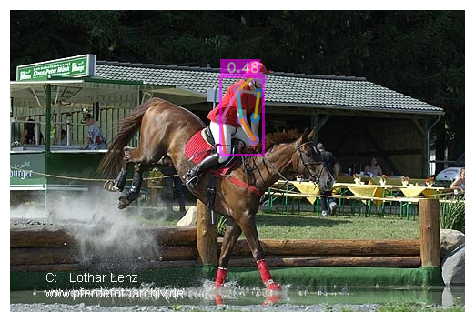

In [13]:
from super_gradients.common.object_names import Models
from super_gradients.training import models

model = models.get(Models.DEKR_W32_NO_DC, pretrained_weights="coco_pose")
model.predict("/content/images/2007_000392.jpg").show()

In Animal Pose dataset the number of joints is set to 20. So we have to change the architecture of the model to output 20 keypoints instead of 17.

Super Gradients provide convenient way to instantiate pre-trained models and override the number of output classes: `models.get(Models.DEKR_W32_NO_DC, num_classes=20, pretrained_weights="coco")`.

What is happening under the hood in this call is the following:
1. `models.get(Models.DEKR_W32_NO_DC, ...)` - this call instantiates the model Models.DEKR_W32_NO_DC with default parameters.
2. `models.get(..., num_classes=20, ...)` - this parameter sets the target number of output classes the model should have. Here it is set to 20 as this is the target number of joints in our dataset.
3. `models.get(..., pretrained_weights="coco")` - this parameter specify what pretrained weights should be loaded into the model. Here we specify that we want to load weights trained on COCO dataset for human pose estimation.


In [14]:
model = models.get(Models.DEKR_W32_NO_DC, num_classes=20, pretrained_weights="coco_pose")

[2023-10-30 16:36:35] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture dekr_w32_no_dc



# Training hyperparameters

Training DEKR model requires passing a specific loss, which we set up in our training hyperparameters. Vanilla DEKR implementation from the paper use MSE loss for heatmap regression. In our approach we use QFL loss instead. Offset loss remains unchanged and default 'l1' term is used:

 ```yaml
    "loss": "dekr_loss",
    "criterion_params": {
        "heatmap_loss": "qfl",
        "heatmap_loss_factor": 1.0,
        "offset_loss_factor": 0.1,
    }
```

We do not use warmup for this example, but you can see how to set it up in the commented out section below:

```yaml
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-3,
    "lr_warmup_epochs": 0,
```

To compute the target metric we add `PoseEstimationMetrics` object to `valid_metrics_list`:

```yaml
    "valid_metrics_list": [
        PoseEstimationMetrics(
            num_joints=20,
            oks_sigmas=None,
            max_objects_per_image=30,
            post_prediction_callback=model.get_post_prediction_callback(conf=0.05, iou=0.05),
        )
    ],
    "metric_to_watch": 'AP',
```

And last but not least, let's add visualization callbacks to see how our training is going. The results will be available in Tensorboard logs:

```yaml
    "phase_callbacks": [
        DEKRVisualizationCallback(mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ], apply_sigmoid=True, phase=Phase.TRAIN_BATCH_END, prefix="train_"),
        DEKRVisualizationCallback(mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ], apply_sigmoid=True, phase=Phase.VALIDATION_BATCH_END, prefix="val"),
    ]
```

Final training params config should look like this:

In [15]:
from super_gradients.training.utils import DEKRVisualizationCallback
from super_gradients.training.metrics import PoseEstimationMetrics
from super_gradients.training.utils.callbacks.callbacks import Phase

train_params = {
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-3,
    "lr_warmup_epochs": 0,
    "initial_lr": 1e-3,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 1e-6},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": False,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 1 EPOCHS FOR THIS EXAMPLE NOTEBOOK TO REDUCE TRAINING TIME!
    # Increase the number of epoch to improve the training results.
    "max_epochs": 1,
    "mixed_precision": True,
    "loss": "dekr_loss",
    "criterion_params": {
        "heatmap_loss": "qfl",
        "heatmap_loss_factor": 1.0,
        "offset_loss_factor": 0.1,
    },
    "valid_metrics_list": [
        PoseEstimationMetrics(
            num_joints=20,
            oks_sigmas=None,
            max_objects_per_image=30,
            post_prediction_callback=model.get_post_prediction_callback(conf=0.05),
        )
    ],
    "metric_to_watch": 'AP',
    "phase_callbacks": [
        DEKRVisualizationCallback(mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ], apply_sigmoid=True, phase=Phase.TRAIN_BATCH_END, prefix="train_"),
        DEKRVisualizationCallback(mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ], apply_sigmoid=True, phase=Phase.VALIDATION_BATCH_END, prefix="val"),
    ]
}


[2023-10-30 16:36:35] WARNING - pose_estimation_metrics.py - Using default OKS sigmas of `0.1` for a custom dataset with 20 joints. To silence this warning, you may want to specify OKS sigmas explicitly as it has direct impact on the AP score.


In [16]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

You can start a tensorboard with the following code:

In [27]:
# Uncomment this if you want to start the tensorboard

# %load_ext tensorboard
# %tensorboard --logdir checkpoints

In [18]:
trainer = Trainer(experiment_name='animal_pose_fine_tuning', ckpt_root_dir=CHECKPOINT_DIR)

In [19]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-10-30 16:36:44] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231030_163644_114603`
[2023-10-30 16:36:44] INFO - sg_trainer.py - Checkpoints directory: checkpoints/animal_pose_fine_tuning/RUN_20231030_163644_114603
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `dekr_loss` is now deprecated. Please replace it with `DEKRLoss`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will c

The console stream is now moved to checkpoints/animal_pose_fine_tuning/RUN_20231030_163644_114603/console_Oct30_16_36_44.txt


[2023-10-30 16:36:46] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3686       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         460        (len(train_loader))
    - Gradient updates per epoch:   460        (len(train_loader) / batch_accumulate)

[2023-10-30 16:36:46] INFO - sg_trainer.py - Started training for 1 epochs (0/0)

Train epoch 0:   0%|          | 0/460 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  war

SUMMARY OF EPOCH 0
├── Train
│   ├── Dekrloss/heatmap = 0.0111
│   ├── Dekrloss/offset = 0.0032
│   └── Dekrloss/total = 0.0143
└── Validation
    ├── Dekrloss/heatmap = 0.0012
    ├── Dekrloss/offset = 0.0025
    ├── Dekrloss/total = 0.0037
    ├── Ap = 0.0027
    └── Ar = 0.0183



[2023-10-30 16:47:05] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 1: 100%|██████████| 116/116 [01:22<00:00,  2.12it/s]

# Predicting with trained model

Let's inspect how our trained model works after training for 1 epochs. For this we use the [predict API](https://docs.deci.ai/super-gradients/documentation/source/ModelPredictions.html) available for Super Gradient models.

In the nutshell, all you need to do is to call `model.predict(image)`, where image can be anything from numpy array, image url, a folder with images of video file.  

In [21]:
model = models.get(Models.DEKR_W32_NO_DC, num_classes=20, checkpoint_path=f"{trainer.checkpoints_dir_path}/ckpt_best.pth")

[2023-10-30 16:57:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


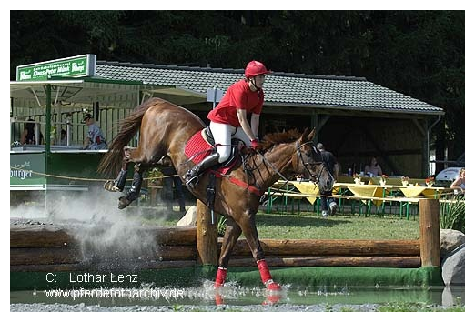

In [23]:
model.predict("/content/images/2007_000392.jpg").show()

As you can see 1 epoch is not enough for the model to properly learn. We run for only 1 epoch to make the notebook quick to run, but feel free to increase the number of epochs (10 for instance) and see the results.

# Conclusion

To summarize, this notebooks demonstrated:
* How to parse external dataset and implement a custom dataset class for pose estimation task
* How to leverate existing base class for pose estimation tasks from Super Gradients
* How to override dataset transforms to ensure transforms operate on a correct skeleton definition
* How to instantiate DEKR model and override number of output joints for animal pose estimation
* How to train model and visualize training progress using Tensorboard
* How to use predict API to visualize the results

## Home assignment

We hope this tutorial inspire you to play with different hyperparameters and maybe other datasets. Here are a few things you can try and see what happens:

1. Try increasing number of training epochs. 10 epochs can be too few
2. You can also try training a smaller model, since it may train in less time.
3. Try different learning rate, EMA settings and weight decay
4. Investigate what the impact on assigning different weights to heatmap & offset components of the loss.

We wish you good luck on your journey. If there is any questions or issues with the tutorial, feel free to reach out via [Super Gradient's Issues](https://github.com/Deci-AI/super-gradients/issues) page.